In [1]:
# install gdown
! pip install gdown >  /dev/null

In [2]:
# downlaod dataset
! gdown "1och-QmNa3FAiS-wssgzCwISbmpSezIi_"

Downloading...
From (uriginal): https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_
From (redirected): https://drive.google.com/uc?id=1och-QmNa3FAiS-wssgzCwISbmpSezIi_&confirm=t&uuid=570f3545-1175-4682-a076-aa539c5974b9
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 1.70G/1.70G [00:11<00:00, 147MB/s]


In [3]:
# unzip to dataset folder
! unzip dataset.zip > /dev/null

In [23]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [24]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (512, 512)

In [6]:
train_dataset, val_dataset = tf.keras.utils.image_dataset_from_directory("./dataset",
                                                                            validation_split=0.2,
                                                                            subset="both",
                                                                            batch_size=BATCH_SIZE,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='binary',
                                                                            seed=123)

Found 922 files belonging to 2 classes.
Using 738 files for training.
Using 184 files for validation.


In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])
preprocess_input = tf.keras.applications.efficientnet.preprocess_input

In [8]:
# Create the base model from the pre-trained model 
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.EfficientNetB4(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

71686520/71686520 [==============================] - 3s 0us/step


In [9]:
base_model.trainable = False

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.models.Sequential([
    # tf.keras.layers.Dense(128),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [11]:
inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [12]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
loss0, accuracy0 = model.evaluate(val_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 [==============================] - 16s 879ms/step - loss: 0.7536 - accuracy: 0.5326
initial loss: 0.75
initial accuracy: 0.53


In [14]:
initial_epochs = 15
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=val_dataset)

Epoch 1/15
24/24 [==============================] - 53s 1s/step - loss: 0.7088 - accuracy: 0.5000 - val_loss: 0.6823 - val_accuracy: 0.5435
Epoch 2/15
24/24 [==============================] - 40s 1s/step - loss: 0.6522 - accuracy: 0.5312 - val_loss: 0.6262 - val_accuracy: 0.5598
Epoch 3/15
24/24 [==============================] - 38s 1s/step - loss: 0.6071 - accuracy: 0.5840 - val_loss: 0.5801 - val_accuracy: 0.5815
Epoch 4/15
24/24 [==============================] - 39s 1s/step - loss: 0.5617 - accuracy: 0.6314 - val_loss: 0.5404 - val_accuracy: 0.6196
Epoch 5/15
24/24 [==============================] - 39s 1s/step - loss: 0.5423 - accuracy: 0.6531 - val_loss: 0.5053 - val_accuracy: 0.6739
Epoch 6/15
24/24 [==============================] - 40s 1s/step - loss: 0.5028 - accuracy: 0.7033 - val_loss: 0.4755 - val_accuracy: 0.7011
Epoch 7/15
24/24 [==============================] - 39s 1s/step - loss: 0.4849 - accuracy: 0.7493 - val_loss: 0.4489 - val_accuracy: 0.7283
Epoch 8/15
24/24 [==

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [16]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 220

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [18]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_dataset,
                         callbacks=callbacks)

Epoch 15/30
24/24 [==============================] - 94s 2s/step - loss: 0.1558 - accuracy: 0.9472 - val_loss: 0.0554 - val_accuracy: 0.9783
Epoch 16/30
24/24 [==============================] - 44s 1s/step - loss: 0.0441 - accuracy: 0.9892 - val_loss: 0.0267 - val_accuracy: 0.9891
Epoch 17/30
24/24 [==============================] - 44s 1s/step - loss: 0.0231 - accuracy: 0.9919 - val_loss: 0.0164 - val_accuracy: 0.9946
Epoch 18/30
24/24 [==============================] - 44s 1s/step - loss: 0.0142 - accuracy: 0.9919 - val_loss: 0.0185 - val_accuracy: 0.9946
Epoch 19/30
24/24 [==============================] - 44s 1s/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.0866 - val_accuracy: 0.9728
Epoch 20/30
24/24 [==============================] - 43s 1s/step - loss: 0.0155 - accuracy: 0.9919 - val_loss: 0.0199 - val_accuracy: 0.9891
Epoch 21/30
24/24 [==============================] - 44s 1s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 1.0000
Epoch 22/30
2

In [22]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

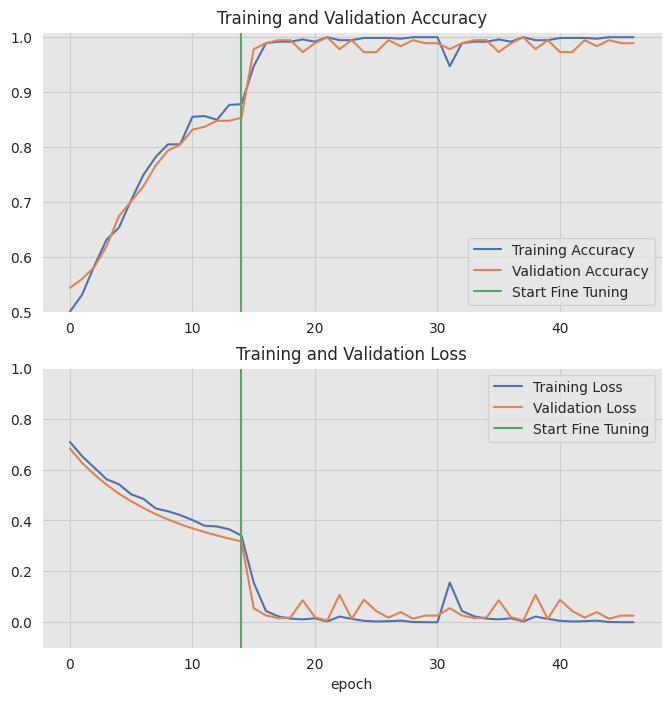

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
sns.lineplot(x=range(len(acc)), y=acc, label='Training Accuracy')
sns.lineplot(x=range(len(val_acc)), y=val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.01])
plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
sns.lineplot(x=range(len(loss)), y=loss, label='Training Loss')
sns.lineplot(x=range(len(val_loss)), y=val_loss, label='Validation Loss')
plt.ylim([-0.1, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [30]:
from sklearn.metrics import classification_report

y_true = np.concatenate([y for x, y in val_dataset], axis=0)

logits = model.predict(val_dataset).flatten()
props = tf.nn.sigmoid(logits)
predictions = tf.where(props < 0.5, 0, 1)

print(classification_report(y_true, predictions))

6/6 [==============================] - 6s 900ms/step
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        99
         1.0       1.00      0.98      0.99        85

    accuracy                           0.99       184
   macro avg       0.99      0.99      0.99       184
weighted avg       0.99      0.99      0.99       184



In [ ]:
# save model
model.save('model.h5')

In [ ]:
# create a text file and save predictions
